In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 22})
# Standard includes
import datetime
import re
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import matplotlib.pyplot as plt
from time import time
import timeit
import numpy as np

In [2]:
# Define query for the tasks
taskQuery = {
    "query": {
        "bool": {
            "should": [
                {"term":{"transhome": "AthDerivation-21.2.8.0"}}
                #{"term":{"transhome": "AthDerivation-21.2.9.0"}}
                #{"term":{"transhome": "AthDerivation-21.2.10.0"}}
            ]
        }
    }
}

In [3]:
# Execute the queries
es = Elasticsearch(['atlas-kibana-dev.mwt2.org'],timeout=120)

# Tasks
taskIndex = "tasks*"
tasks = scan(es, query=taskQuery, index=taskIndex, scroll='5m', timeout="5m", size=1000)        

In [4]:
# List the available information
#count = 0
#for res in tasks:
    #if count>0:
    #    break
    #count += 1
    #print ("Available keys = ",res.keys())
#    print("_index = ",res['_index']) #str
#    print("_source = ",res['_source'].keys()) #dict
#    print("_id = ",res['_id']) #str
#    print("sort = ",res['sort']) #list
#    print("_type = ",res['_type']) #str
#    print("_score = ",res['_score']) #NoneType

In [5]:
# Define the trains and the quantities for collection
quantities = [
    'cpuconsumptiontime',
    'nevents',
    'starttime',
    'endtime',
    'timeExe',
    'timeSetup',
    'timeGetJob',
    'timeStageIn',
    'timeStageOut',
    'actualcorecount',
    'wall_time',
    'inputfilebytes',
    'outputfilebytes',
    'Max_PSS_per_core'
]

# Data structure as follows:
# List of tuples, one per train, with following contents:
# ( [List of carriages in the train],[list of jobs for that train],{map of quantity name->list of values for the jobs})
trainsAndIDs = [
    (['DAOD_HIGG2D5','DAOD_FTAG3','DAOD_TCAL1'],[],{}),
    (['DAOD_JETM10','DAOD_EGAM4','DAOD_STDM5','DAOD_MUON2'],[],{}),
    (['DAOD_HIGG1D2','DAOD_EXOT12','DAOD_EGAM9'],[],{}),
    (['DAOD_SUSY2','DAOD_SUSY12','DAOD_JETM3','DAOD_EGAM3','DAOD_EXOT0','DAOD_EXOT17'],[],{}),
    (['DAOD_JETM7','DAOD_EXOT6','DAOD_EGAM2','DAOD_BPHY8'],[],{}),
    (['DAOD_BPHY7'],[],{}),
    (['DAOD_EXOT9','DAOD_EGAM7'],[],{}),
    (['DAOD_SUSY16','DAOD_EXOT20','DAOD_STDM3'],[],{}),
    (['DAOD_SUSY18','DAOD_JETM4','DAOD_HIGG4D1','DAOD_HIGG6D1'],[],{}),
    (['DAOD_EXOT18','DAOD_SUSY3','DAOD_EXOT5','DAOD_STDM2'],[],{}),
    (['DAOD_JETM2','DAOD_SUSY11','DAOD_SUSY4','DAOD_JETM6','DAOD_EXOT19','DAOD_EGAM1'],[],{}),
    (['DAOD_JETM1','DAOD_HIGG2D4','DAOD_EGAM8','DAOD_SUSY1','DAOD_SUSY5'],[],{}),
    (['DAOD_HIGG5D3','DAOD_HIGG5D1'],[],{}),
    (['DAOD_SUSY10','DAOD_EGAM5','DAOD_JETM11'],[],{}),
    (['DAOD_TAUP1','DAOD_EXOT13','DAOD_EXOT2'],[],{}),
    (['DAOD_MUON1','DAOD_SUSY6','DAOD_JETM9','DAOD_EXOT8','DAOD_FTAG1'],[],{}),
    (['DAOD_HIGG2D1','DAOD_HIGG5D2'],[],{}),
    (['DAOD_FTAG2','DAOD_FTAG4'],[],{}),
    (['DAOD_HIGG6D2','DAOD_MUON0','DAOD_TAUP3'],[],{})
]

In [6]:
# Get the IDs matching each train

start_time = timeit.default_timer()
matchingTasks = 0
for res in tasks:
    if 'output_formats' in res['_source'].keys():
        for item in trainsAndIDs:
            train = item[0]
            if set(res['_source']['output_formats']) == set(train):
                item[1].append(res['_id'])
                matchingTasks += 1
print("Total matching tasks = ",matchingTasks)
print("Time to extract information = ",timeit.default_timer() - start_time)

Total matching tasks =  9975
Time to extract information =  4.46760462410748


In [7]:
# Set up query for the jobs relevant to the trains
start_time = timeit.default_timer()
taskCounter = 0
jobIndex = "jobs_archive_2018*,jobs_archive_2017*"

to_read = quantities
to_read.append('jeditaskid')
to_read.append('transformation')

for item in trainsAndIDs: # Loop over trains
    #taskCounterPerTrain = 0
    for theId in item[1]: # Loop over tasks for that train
        taskCounter += 1
        #taskCounterPerTrain += 1
        #if taskCounterPerTrain > 10: break
        if taskCounter % 100 == 0: 
            et = timeit.default_timer() - start_time
            print("Processing task ",taskCounter," Elapsed Time:", et, '\t projected finish in:',et/taskCounter*matchingTasks - et )
        jobQuery = {
            "_source": to_read,
            "query": {
                "bool": {
                    "must": [
                        {"term":{"jeditaskid": theId}},
                        {"term":{"jobstatus": "finished"}}
                    ]
                }
            }
        }
        # query the jobs
        jobs = scan(es, query=jobQuery, index=jobIndex, scroll='5m', timeout="5m", size=1000)
        for res in jobs: # Loop over jobs from that task
            for quantity in quantities: # get the relevant quantities
                if quantity in res['_source'].keys(): 
                    if quantity not in item[2].keys(): # store the quantities in a long list
                        item[2][quantity] = [res['_source'][quantity]]
                    else:
                        item[2][quantity].append(res['_source'][quantity])
                    



Processing task  100  Elapsed Time: 19.258262649178505 	 projected finish in: 1901.7534366063771
Processing task  200  Elapsed Time: 38.60966739244759 	 projected finish in: 1887.047493805876
Processing task  300  Elapsed Time: 58.53722454980016 	 projected finish in: 1887.825491731055
Processing task  400  Elapsed Time: 78.28566047549248 	 projected finish in: 1873.9629976321012
Processing task  500  Elapsed Time: 98.25760141015053 	 projected finish in: 1861.9815467223525
Processing task  600  Elapsed Time: 119.23495191708207 	 projected finish in: 1863.0461237044074
Processing task  700  Elapsed Time: 140.56276623532176 	 projected finish in: 1862.456652618013
Processing task  800  Elapsed Time: 160.23410742543638 	 projected finish in: 1837.6849195354735
Processing task  900  Elapsed Time: 183.61235609464347 	 projected finish in: 1851.4245906209883
Processing task  1000  Elapsed Time: 205.44020131602883 	 projected finish in: 1843.8258068113587
Processing task  1100  Elapsed Time:

Processing task  8600  Elapsed Time: 2055.994883539155 	 projected finish in: 328.7201121937601
Processing task  8700  Elapsed Time: 2078.784440429881 	 projected finish in: 304.64944385610306
Processing task  8800  Elapsed Time: 2103.288748167455 	 projected finish in: 280.8368498973591
Processing task  8900  Elapsed Time: 2128.129450732842 	 projected finish in: 257.0493437682926
Processing task  9000  Elapsed Time: 2153.4156543835998 	 projected finish in: 233.28669589155652
Processing task  9100  Elapsed Time: 2177.9054131712765 	 projected finish in: 209.41398203569952
Processing task  9200  Elapsed Time: 2204.568902399391 	 projected finish in: 185.7109673216878
Processing task  9300  Elapsed Time: 2233.853753240779 	 projected finish in: 162.13454660618572
Processing task  9400  Elapsed Time: 2261.7593994718045 	 projected finish in: 138.35230369109422
Processing task  9500  Elapsed Time: 2291.362896366045 	 projected finish in: 114.56814481830224
Processing task  9600  Elapsed 

In [8]:
# Calculate the quantities required for plotting from the raw information
# Note that for this cell and beyond the code is not generic, e.g. it has to be manually configured for
# whatever variables are needed in the plot
meanCPUPerEvent = ([],[]) # Reco, Merge
meanCPU = ([],[]) # (Reco, Merge)
totalCPU = ([],[]) # (Reco, Merge)
totalDuration = ([],[]) # (Reco, Merge)
totalWalltime = ([],[]) # (Reco, Merge)
totalTimeSetup = ([],[])
totalTimeGetJob = ([],[]) # (Reco, Merge)
totalTimeExe = ([],[]) # (Reco, Merge)
totalTimeStageIn = ([],[]) # (Reco, Merge)
totalTimeStageOut = ([],[]) # (Reco, Merge)
cpuOverDuration = ([],[]) # (Reco, Merge)
cpuOverWalltime = ([],[]) # (Reco, Merge)
walltimeOverDuration = ([],[]) # (Reco, Merge)
actualcorecount = ([],[]) # (Reco, Merge)
cpuIntensity = ([],[]) # (Reco, Merge)
#maxPSSPerCore = ([],[]) # (Reco, Merge)

for train in trainsAndIDs:
    cpuconsumptiontime = (np.asarray(train[2]['cpuconsumptiontime'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                          np.asarray(train[2]['cpuconsumptiontime'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
                         )
    nevents = (np.asarray(train[2]['nevents'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
               np.asarray(train[2]['nevents'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
              )
    starttimes = (np.array(train[2]['starttime'],dtype='datetime64')[np.array(train[2]['transformation'])=="Reco_tf.py"],
                  np.array(train[2]['starttime'],dtype='datetime64')[np.array(train[2]['transformation'])=="DAODMerge_tf.py"]
                 )
    endtimes = (np.array(train[2]['endtime'],dtype='datetime64')[np.array(train[2]['transformation'])=="Reco_tf.py"],
                np.array(train[2]['endtime'],dtype='datetime64')[np.array(train[2]['transformation'])=="DAODMerge_tf.py"]
               )
    setupTimes = (np.asarray(train[2]['timeSetup'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                  np.asarray(train[2]['timeSetup'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
                 )
    getJobTimes = (np.asarray(train[2]['timeGetJob'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                   np.asarray(train[2]['timeGetJob'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
                  )
    exeTimes = (np.asarray(train[2]['timeExe'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                np.asarray(train[2]['timeExe'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
               )
    stageInTimes = (np.asarray(train[2]['timeStageIn'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                    np.asarray(train[2]['timeStageIn'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
                   )
    stageOutTimes = (np.asarray(train[2]['timeStageOut'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                     np.asarray(train[2]['timeStageOut'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
                    )
    actualcorecount = (np.asarray(train[2]['actualcorecount'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                       np.asarray(train[2]['actualcorecount'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
                      ) 
    wall_time = (np.asarray(train[2]['wall_time'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                 np.asarray(train[2]['wall_time'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
                )
    inputSize = (np.asarray(train[2]['inputfilebytes'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                 np.asarray(train[2]['inputfilebytes'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
                )
    outputSize = (np.asarray(train[2]['outputfilebytes'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
                  np.asarray(train[2]['outputfilebytes'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
                 )
    #Max_PSS_per_core = (np.asarray(train[2]['Max_PSS_per_core'])[np.asarray(train[2]['transformation'])=="Reco_tf.py"],
    #                    np.asarray(train[2]['Max_PSS_per_core'])[np.asarray(train[2]['transformation'])=="DAODMerge_tf.py"]
    #                   )
    
    cpuPerEvent = (cpuconsumptiontime[0]/nevents[0],cpuconsumptiontime[1]/nevents[1])
    cpuPerEvent = (cpuPerEvent[0][np.isfinite(cpuPerEvent[0])],cpuPerEvent[1][np.isfinite(cpuPerEvent[1])])
    meanCPUPerEvent[0].append(cpuPerEvent[0].mean())
    meanCPUPerEvent[1].append(cpuPerEvent[1].mean())
    meanCPU[0].append(cpuconsumptiontime[0].mean())
    meanCPU[1].append(cpuconsumptiontime[1].mean())
    totalCPU[0].append(cpuconsumptiontime[0].sum())
    totalCPU[1].append(cpuconsumptiontime[1].sum())
    totalDuration[0].append((endtimes[0]-starttimes[0]).sum())
    totalDuration[1].append((endtimes[1]-starttimes[1]).sum())
    totalWalltime[0].append(wall_time[0].sum())
    totalWalltime[1].append(wall_time[1].sum())
    totalTimeSetup[0].append(setupTimes[0].sum())
    totalTimeSetup[1].append(setupTimes[1].sum())
    totalTimeGetJob[0].append(getJobTimes[0].sum())
    totalTimeGetJob[1].append(getJobTimes[1].sum())
    totalTimeExe[0].append(exeTimes[0].sum())
    totalTimeExe[1].append(exeTimes[1].sum())
    totalTimeStageIn[0].append(stageInTimes[0].sum())
    totalTimeStageIn[1].append(stageInTimes[1].sum())
    totalTimeStageOut[0].append(stageOutTimes[0].sum())
    totalTimeStageOut[1].append(stageOutTimes[1].sum())
    cpuOverDuration[0].append((cpuconsumptiontime[0]/actualcorecount[0]).sum()/((endtimes[0]-starttimes[0]).sum()/np.timedelta64(1, 's')))
    cpuOverDuration[1].append((cpuconsumptiontime[1]/actualcorecount[1]).sum()/((endtimes[1]-starttimes[1]).sum()/np.timedelta64(1, 's')))
    cpuOverWalltime[0].append((cpuconsumptiontime[0]/actualcorecount[0]).sum()/wall_time[0].sum())
    cpuOverWalltime[1].append((cpuconsumptiontime[1]/actualcorecount[1]).sum()/wall_time[1].sum())
    walltimeOverDuration[0].append(wall_time[0].sum()/((endtimes[0]-starttimes[0]).sum()/np.timedelta64(1, 's')))
    walltimeOverDuration[1].append(wall_time[1].sum()/((endtimes[1]-starttimes[1]).sum()/np.timedelta64(1, 's')))
    cpuIntensity[0].append( ((inputSize[0]+outputSize[0]).sum()/1000000.0)/wall_time[0].sum() )
    cpuIntensity[1].append( ((inputSize[1]+outputSize[1]).sum()/1000000.0)/wall_time[1].sum() )
    #maxPSSPerCore[0].append( Max_PSS_per_core[0].sum())
    #maxPSSPerCore[1].append( Max_PSS_per_core[1].sum())    

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide


In [9]:
# Set up flat names for the tick labels
train_names = []
for item in trainsAndIDs:
    names = item[0]
    longName = ''
    for name in names:
        name = name.strip("DAOD_")
        longName += name+' '
    train_names.append(longName)

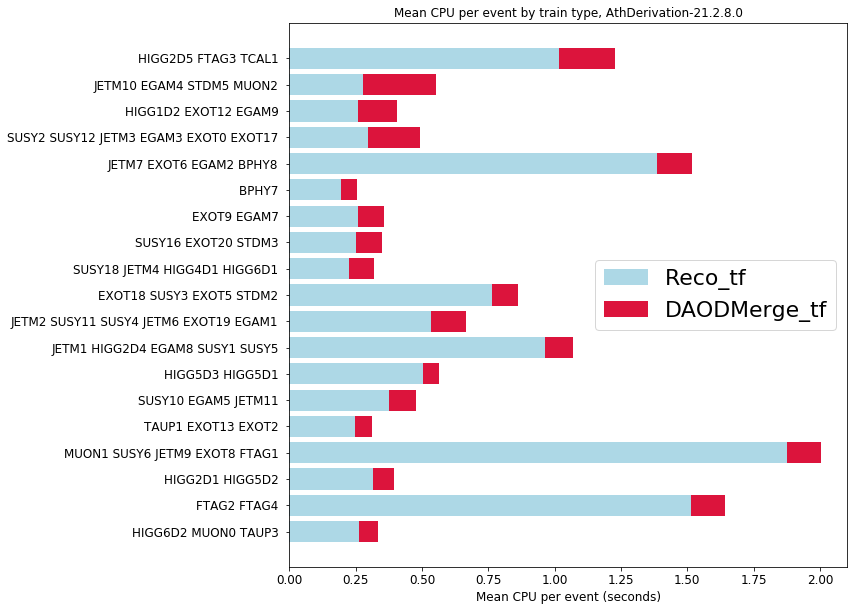

In [10]:
# Plotting - mean CPU per event by train type
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
ax.barh(y_pos, meanCPUPerEvent[0], align='center',color='lightblue',label="Reco_tf")
ax.barh(y_pos, meanCPUPerEvent[1], align='center',color='crimson',left=meanCPUPerEvent[0],label="DAODMerge_tf")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Mean CPU per event (seconds)',fontsize=12)
ax.set_title('Mean CPU per event by train type, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend()
plt.show()

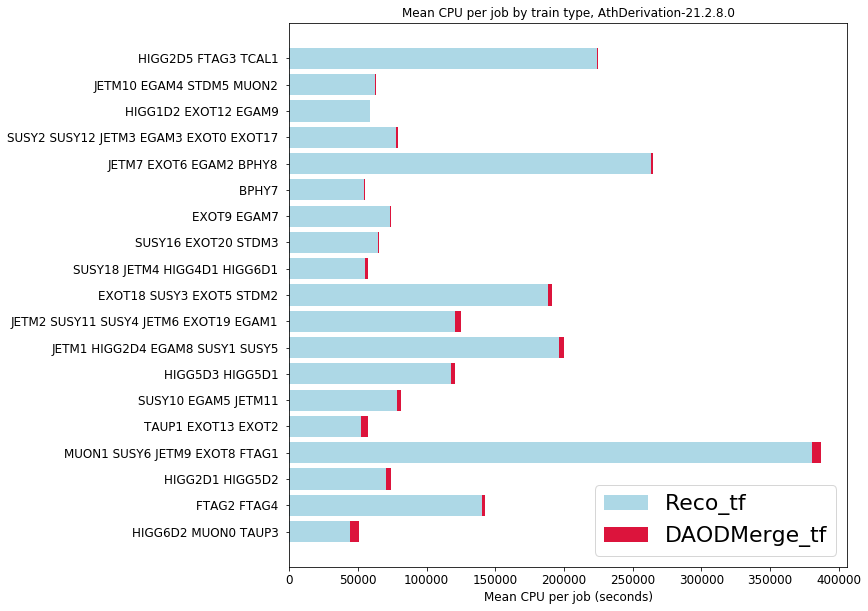

In [11]:
# Plotting - mean CPU per job by train type
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
ax.barh(y_pos, meanCPU[0], align='center',color='lightblue',label="Reco_tf")
ax.barh(y_pos, meanCPU[1], align='center',color='crimson',left=meanCPU[0],label="DAODMerge_tf")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Mean CPU per job (seconds)',fontsize=12)
ax.set_title('Mean CPU per job by train type, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend()
plt.show()

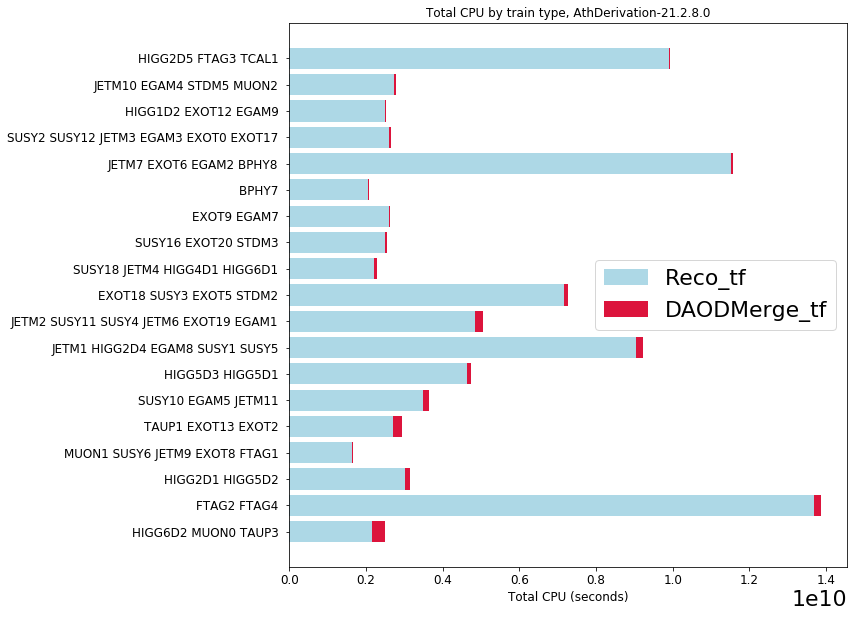

In [12]:
# Plotting - total CPU by train type
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
ax.barh(y_pos, totalCPU[0], align='center',color='lightblue',label="Reco_tf")
ax.barh(y_pos, totalCPU[1], align='center',color='crimson',left=totalCPU[0],label="DAODMerge_tf")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Total CPU (seconds)',fontsize=12)
ax.set_title('Total CPU by train type, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend()
plt.show()

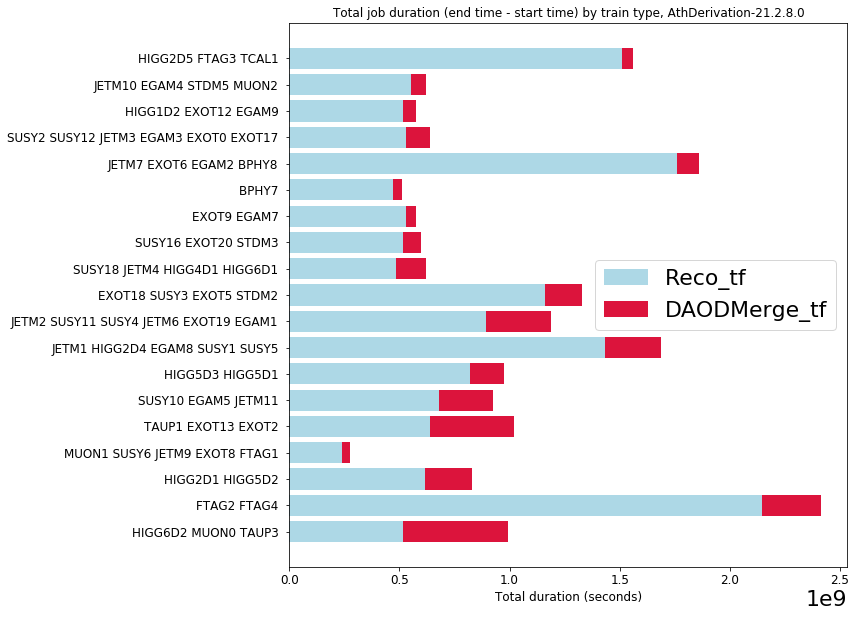

In [13]:
# Plotting
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
ax.barh(y_pos, totalDuration[0]/np.timedelta64(1, 's'), align='center',color='lightblue',label="Reco_tf")
ax.barh(y_pos, totalDuration[1]/np.timedelta64(1, 's'), align='center',color='crimson',left=totalDuration[0]/np.timedelta64(1, 's'),label="DAODMerge_tf")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Total duration (seconds)',fontsize=12)
ax.set_title('Total job duration (end time - start time) by train type, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend()
plt.show()

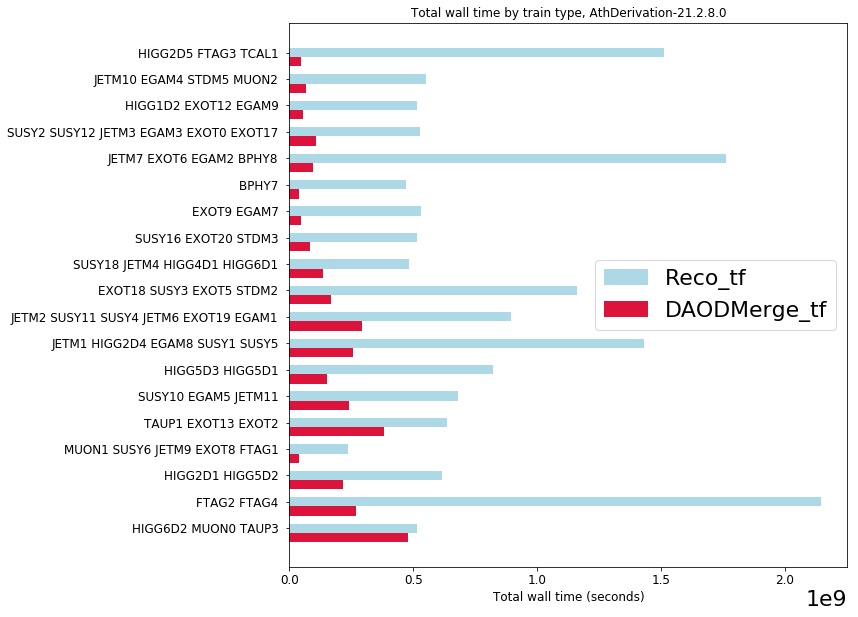

In [14]:
# Plotting - total wall time
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
width=0.35
rects1 = ax.barh(y_pos, totalWalltime[0], width,color='lightblue',label="Reco_tf")
rects2 = ax.barh(y_pos+width, totalWalltime[1], width,color='crimson',label="DAODMerge_tf")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Total wall time (seconds)',fontsize=12)
ax.set_title('Total wall time by train type, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend()
plt.show()

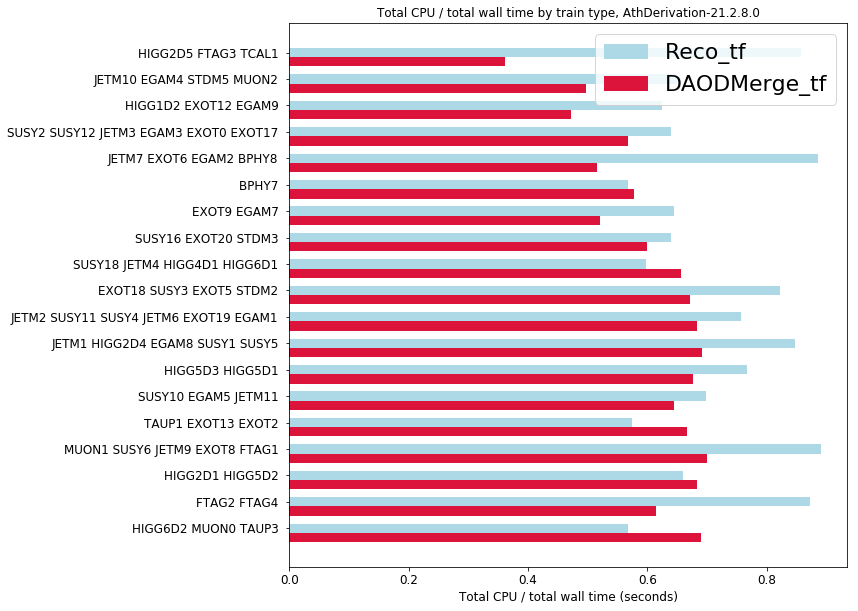

In [15]:
# Plotting - total CPU / total wall time
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
width=0.35
rects1 = ax.barh(y_pos, cpuOverWalltime[0], width,color='lightblue',label="Reco_tf")
rects2 = ax.barh(y_pos+width, cpuOverWalltime[1], width,color='crimson',label="DAODMerge_tf")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Total CPU / total wall time (seconds)',fontsize=12)
ax.set_title('Total CPU / total wall time by train type, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend()
plt.show()

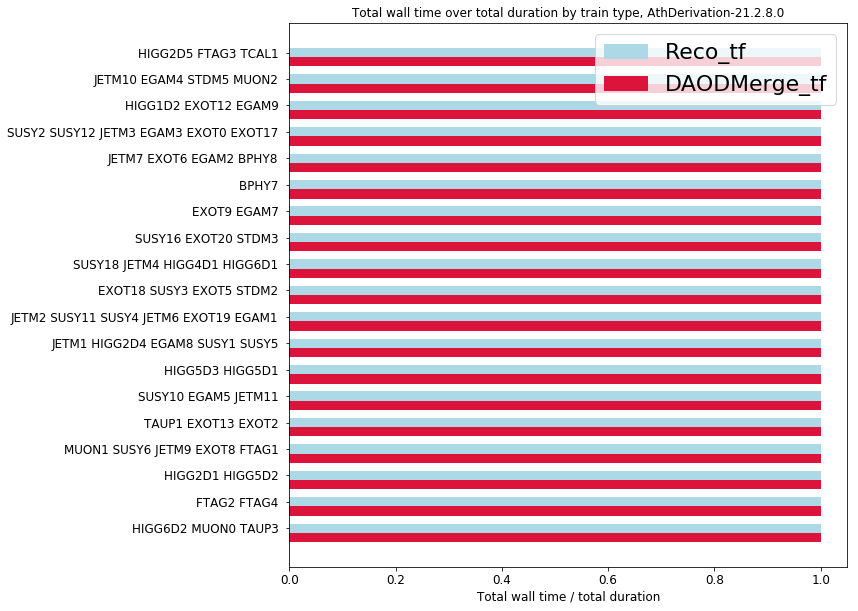

In [16]:
# Plotting - total wall time / total duration
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
width=0.35
rects1 = ax.barh(y_pos, walltimeOverDuration[0], width,color='lightblue',label="Reco_tf")
rects2 = ax.barh(y_pos+width, walltimeOverDuration[1], width,color='crimson',label="DAODMerge_tf")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Total wall time / total duration',fontsize=12)
ax.set_title('Total wall time over total duration by train type, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend()
plt.show()

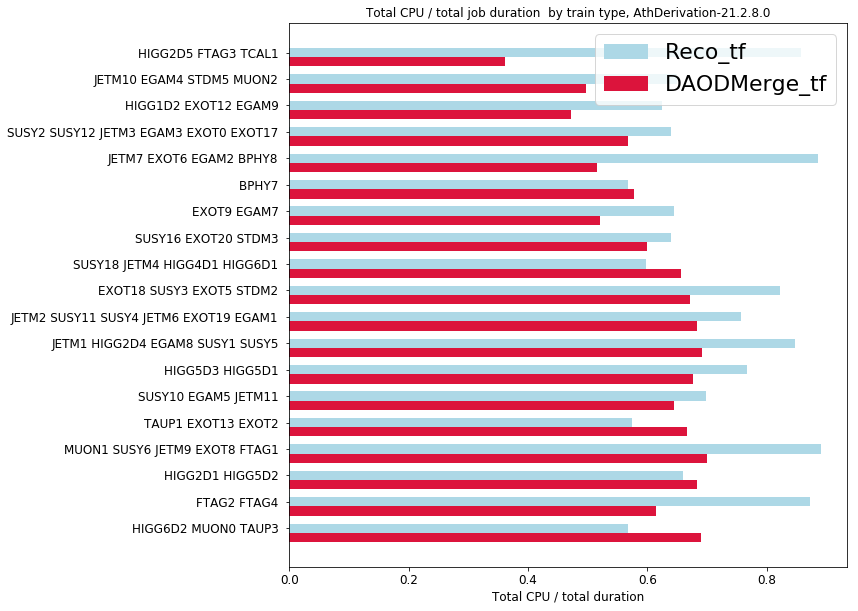

In [17]:
# Plotting - total CPU / total duration
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
width=0.35
rects1 = ax.barh(y_pos, cpuOverDuration[0], width,color='lightblue',label="Reco_tf")
rects2 = ax.barh(y_pos+width, cpuOverDuration[1], width,color='crimson',label="DAODMerge_tf")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Total CPU / total duration',fontsize=12)
ax.set_title('Total CPU / total job duration  by train type, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend()
plt.show()

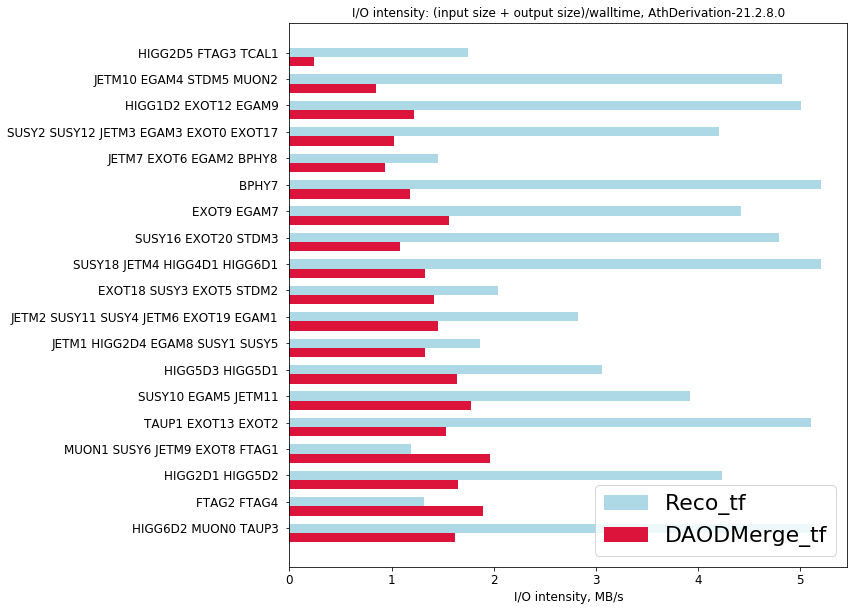

In [18]:
# Plotting - I/O intensity
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
width=0.35
rects1 = ax.barh(y_pos, cpuIntensity[0], width,color='lightblue',label="Reco_tf")
rects2 = ax.barh(y_pos+width, cpuIntensity[1], width,color='crimson',label="DAODMerge_tf")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('I/O intensity, MB/s',fontsize=12)
ax.set_title('I/O intensity: (input size + output size)/walltime, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend()
plt.show()

In [19]:
# Plotting - max PSS per core
#fig, ax = plt.subplots(figsize=(10,10))
#y_pos = np.arange(len(train_names))
#width=0.35
#rects1 = ax.barh(y_pos, maxPSSPerCore[0], width,color='lightblue',label="Reco_tf")
#rects2 = ax.barh(y_pos+width, maxPSSPerCore[1], width,color='crimson',label="DAODMerge_tf")
#ax.set_yticks(y_pos)
#ax.set_yticklabels(train_names,fontsize=12)
#ax.invert_yaxis() 
#ax.set_xlabel('Max PSS per core, GB',fontsize=12)
#ax.set_title('Maxx PSS per core, AthDerivation-21.2.8.0',fontsize=12)
#ax.tick_params(axis='x', labelsize=12)
#plt.legend()
#plt.show()

In [20]:
# Colours
import matplotlib.cm as cm
viridis = cm.viridis(np.linspace(0, 1, 5))
magma = cm.magma(np.linspace(0, 1, 5))

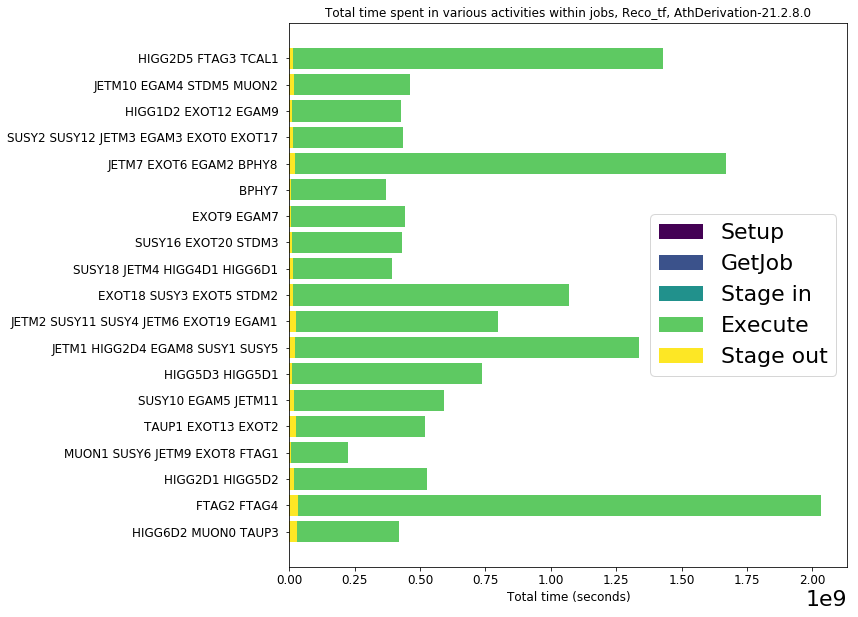

In [21]:
# Plotting
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
ax.barh(y_pos, totalTimeSetup[0], align='center',color=viridis[0],label="Setup")
ax.barh(y_pos, totalTimeGetJob[0], align='center',color=viridis[1],left=totalTimeSetup[0],label="GetJob")
ax.barh(y_pos, totalTimeStageIn[0], align='center',color=viridis[2],left=totalTimeSetup[0],label="Stage in")
ax.barh(y_pos, totalTimeExe[0], align='center',color=viridis[3],left=totalTimeSetup[0],label="Execute")
ax.barh(y_pos, totalTimeStageOut[0], align='center',color=viridis[4],left=totalTimeSetup[0],label="Stage out")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Total time (seconds)',fontsize=12)
ax.set_title('Total time spent in various activities within jobs, Reco_tf, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
#ax.set_xscale('log')
plt.legend()
plt.show()

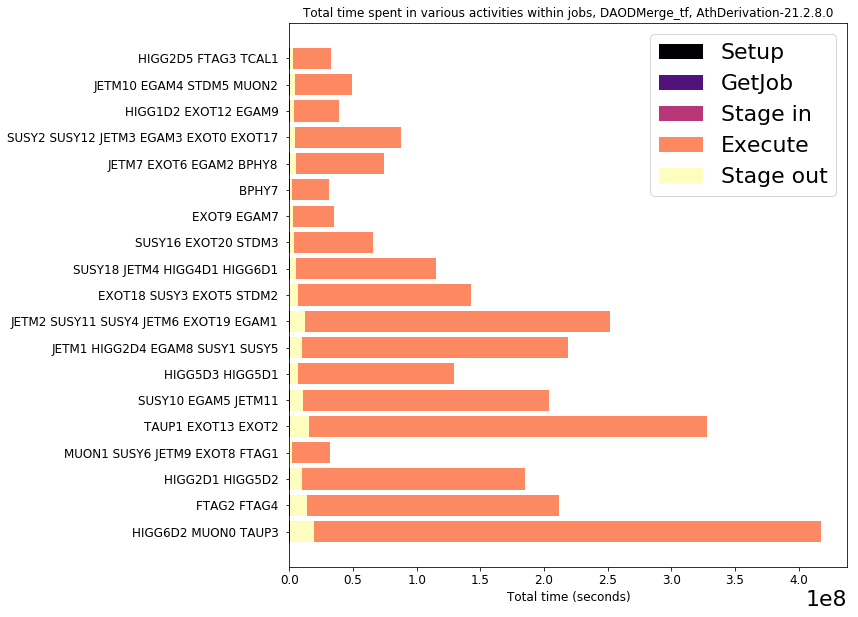

In [22]:
# Plotting
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(train_names))
ax.barh(y_pos, totalTimeSetup[1], align='center',color=magma[0],label="Setup")
ax.barh(y_pos, totalTimeGetJob[1], align='center',color=magma[1],left=totalTimeSetup[0],label="GetJob")
ax.barh(y_pos, totalTimeStageIn[1], align='center',color=magma[2],left=totalTimeSetup[0],label="Stage in")
ax.barh(y_pos, totalTimeExe[1], align='center',color=magma[3],left=totalTimeSetup[0],label="Execute")
ax.barh(y_pos, totalTimeStageOut[1], align='center',color=magma[4],left=totalTimeSetup[0],label="Stage out")
ax.set_yticks(y_pos)
ax.set_yticklabels(train_names,fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Total time (seconds)',fontsize=12)
ax.set_title('Total time spent in various activities within jobs, DAODMerge_tf, AthDerivation-21.2.8.0',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
#ax.set_xscale('log')
plt.legend()
plt.show()